# **Melanoma Detection Assignment**

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

## **Data Reading / Data Understanding**

### Importing all the important libraries

In [ ]:
!pip install Augmentor

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import os
import shutil
import PIL
import Augmentor
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import load_img
from glob import glob

from sklearn.metrics import confusion_matrix, classification_report

from google.colab import files
from google.colab import drive
import zipfile

In [ ]:
## mounting the google drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/My Drive/coding/Train")
data_dir_test = pathlib.Path('/content/gdrive/My Drive/coding/Test')

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

## **Load using keras.preprocessing**

Let's load these images off disk using the helpful image_dataset_from_directory utility.

## **Dataset Creation**

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,  # 20% of data will be used for validation
    subset="training",  # Correct value to select only the training data
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,  # 20% of data will be used for validation
    subset="validation",  # Correct value to select only validation data
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# Load test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,  # No need to shuffle for evaluation
    label_mode="int"  # Ensures labels are integers (for sparse_categorical_crossentropy)
)

Found 118 files belonging to 9 classes.


In [ ]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = test_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## **Visualize the data**
#### Code to visualize one instance of all the nine classes present in the dataset

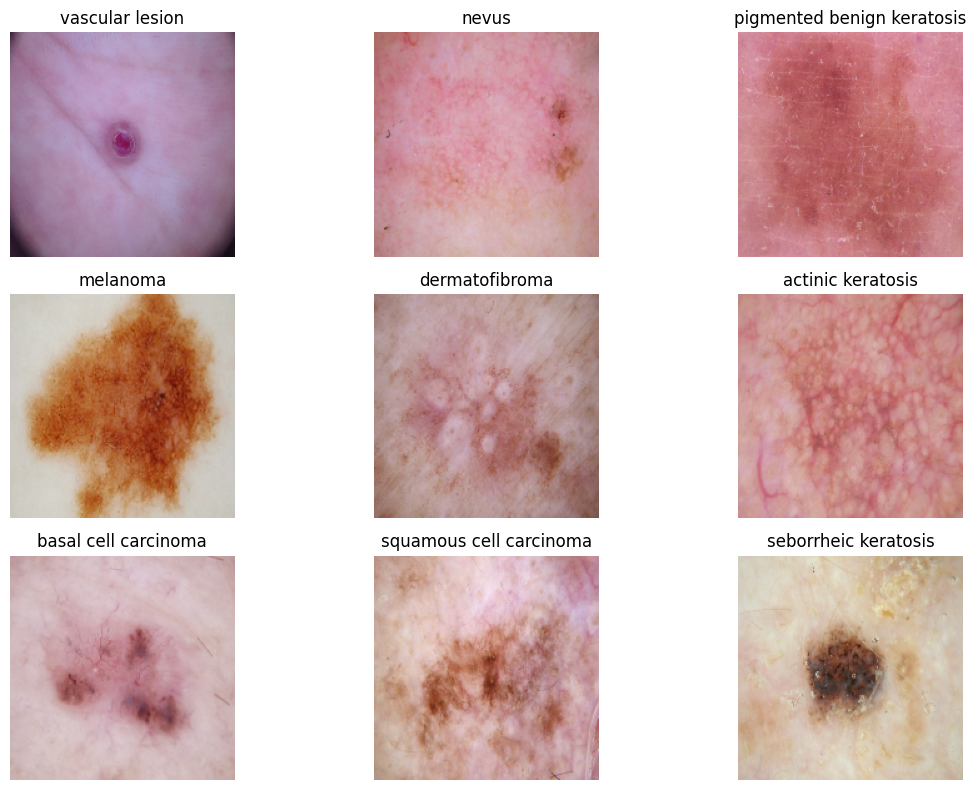

In [ ]:
# Create a dictionary to store one image per class
class_images = {}

# Loop through the dataset to get one image per class
for images, labels in train_ds:
    for img, label in zip(images, labels.numpy()):
        class_name = class_names[label]
        if class_name not in class_images:
            class_images[class_name] = img.numpy().astype("uint8")
        if len(class_images) == len(class_names):  # Stop if all classes are covered
            break
    if len(class_images) == len(class_names):
        break

# Plot one image per class
plt.figure(figsize=(12, 8))
for i, (class_name, img) in enumerate(class_images.items()):
    plt.subplot(3, 3, i + 1)  # Assuming 9 classes (3x3 grid)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis("off")

plt.tight_layout()
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## **Create the model - Initial Model**
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
# Build the CNN model
model = keras.Sequential([
    # Normalize pixel values (0-1)
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    # First Convolutional Block
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Second Convolutional Block
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Third Convolutional Block
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Flatten and Fully Connected Layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')  # Output layer
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## **Compile the initial model**
Choose an appropirate optimiser and loss function for model training

In [ ]:
### choose an appropirate optimiser and loss function
model.compile(optimizer='adamW',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       7,929,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,024,393 (30.61 MB)

 Trainable params: 8,024,393 (30.61 MB)

 Non-trainable params: 0 (0.00 B)

## **Train the Initial model**

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 296s 2s/step - accuracy: 0.1773 - loss: 2.4913 - val_accuracy: 0.3043 - val_loss: 1.9450
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.2977 - loss: 1.9058 - val_accuracy: 0.3535 - val_loss: 1.7984
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.3887 - loss: 1.6857 - val_accuracy: 0.4251 - val_loss: 1.6079
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.4582 - loss: 1.5211 - val_accuracy: 0.5078 - val_loss: 1.4318
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.4962 - loss: 1.3673 - val_accuracy: 0.4765 - val_loss: 1.5363
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5439 - loss: 1.2735 - val_accuracy: 0.5280 - val_loss: 1.4056
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5837 - loss: 1.1952 - val_accuracy: 0.4810 - val_loss: 1.5193
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5967 - loss: 1.0868 - val_accuracy: 0.5324 - v

## **Visualizing training results - Initial Model**

Training Accuracy: 86.44%
Validation Accuracy: 49.66%
Training Loss: 35.16%
Validation Loss: 224.96%


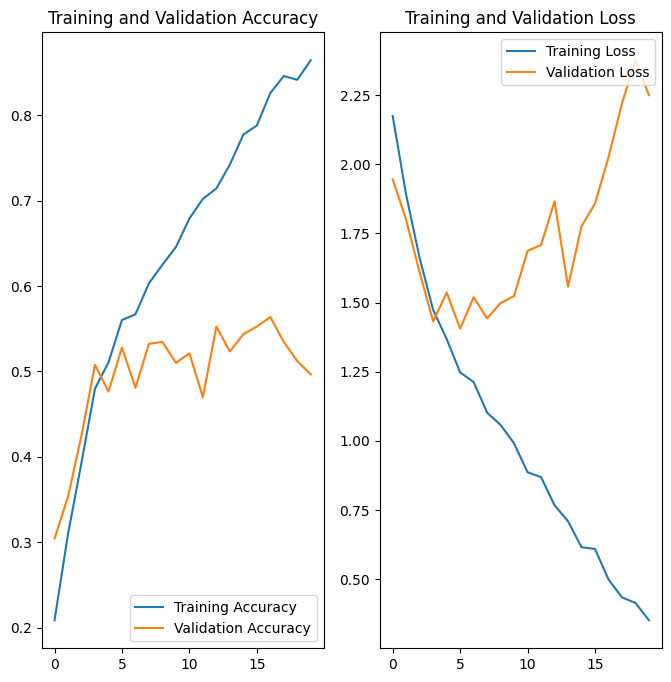

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


train_acc = history.history['accuracy'][-1] * 100
valid_acc = history.history['val_accuracy'][-1] * 100
train_loss = history.history['loss'][-1] * 100
valid_loss = history.history['val_loss'][-1] * 100

print(f"Training Accuracy: {train_acc:.2f}%")
print(f"Validation Accuracy: {valid_acc:.2f}%")
print(f"Training Loss: {train_loss:.2f}%")
print(f"Validation Loss: {valid_loss:.2f}%")

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

## **Findings on the Initial Model**

 -  The model's training accuracy shows a steady increase of upto 86%, while validation accuracy became consistent at around 50-55%.

 -  A high training accuracy suggests the model has effectively captured the noise within the data. However, its poor performance on validation data indicates a lack of generalizability.

 -  These observations confirm the presence of overfitting. To address this issue, augmentation techniques will be employed. Given the limited training data available, new samples will be generated by making slight modifications to existing data (such as horizontal/vertical image flipping, image rotations, etc.), which will then be used for training the model.

After analysing the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.

## **Define an Augmentation Strategy**

Choose an appropriate data augmentation strategy to resolve underfitting / overfitting

In [ ]:
# Define the augmentation strategy
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),  # Randomly flip images horizontally
    layers.RandomRotation(0.25),  # Rotate images by up to 90 degree
    layers.RandomBrightness(0.2),  # Adjust brightness
    layers.RandomContrast(0.2)  # Adjust contrast
])

## **Verify Augmentation**

Visualize how the augmentation strategy works for one instance of training image

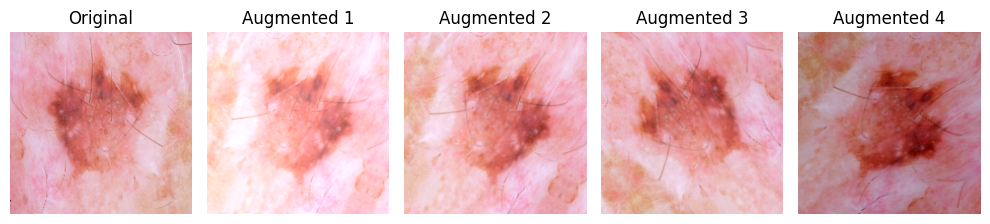

In [ ]:
# Get a batch of images from train_ds
image_batch, _ = next(iter(train_ds))

# Apply augmentation to the first image
augmented_images = [data_augmentation(image_batch[0]) for _ in range(4)]

# Plot original and augmented images
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    if i == 0:
        plt.imshow(image_batch[0].numpy().astype("uint8"))
        plt.title("Original")
    else:
        plt.imshow(augmented_images[i-1].numpy().astype("uint8"))
        plt.title(f"Augmented {i}")
    plt.axis("off")

plt.tight_layout()
plt.show()

## **Create the model - Model using Augumentation strategy**

In [ ]:
# Build the CNN model with augumentation strategy
model = keras.Sequential([

    # Normalize pixel values (0-1)
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    # First Convolutional Block
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Second Convolutional Block
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Third Convolutional Block
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Flatten and Fully Connected Layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')  # Output layer
])

In [ ]:
# Apply augmentation using the map function on the dataset
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)  # Adjust brightness
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)  # Adjust contrast
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))  # Random 90° rotations

    return image, label

train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)  # Apply augmentation to the training dataset

## **Compile the model - Model using Augmentation strategy**
Choose an appropirate optimiser and loss function for model training

In [ ]:
### choose an appropirate optimiser and loss function
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Fixed learning rate
optimizer = tf.keras.optimizers.AdamW()
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       7,929,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,024,393 (30.61 MB)

 Trainable params: 8,024,393 (30.61 MB)

 Non-trainable params: 0 (0.00 B)

## **Train the model - Model using Augmentation strategy**

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.1994 - loss: 2.3174 - val_accuracy: 0.2752 - val_loss: 1.9408
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.3244 - loss: 1.8519 - val_accuracy: 0.3624 - val_loss: 1.7337
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.4282 - loss: 1.6229 - val_accuracy: 0.4922 - val_loss: 1.4735
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.4930 - loss: 1.4796 - val_accuracy: 0.4966 - val_loss: 1.4813
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4722 - loss: 1.4838 - val_accuracy: 0.5302 - val_loss: 1.3350
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.5363 - loss: 1.3521 - val_accuracy: 0.5190 - val_loss: 1.3795
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.5491 - loss: 1.2850 - val_accuracy: 0.4855 - val_loss: 1.4459
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.5371 - loss: 1.3156 - val_accuracy: 0.5101 - v

## **Visualizing training results - Model using Augmentation strategy**

Training Accuracy: 59.43%
Validation Accuracy: 55.48%
Training Loss: 109.61%
Validation Loss: 126.68%


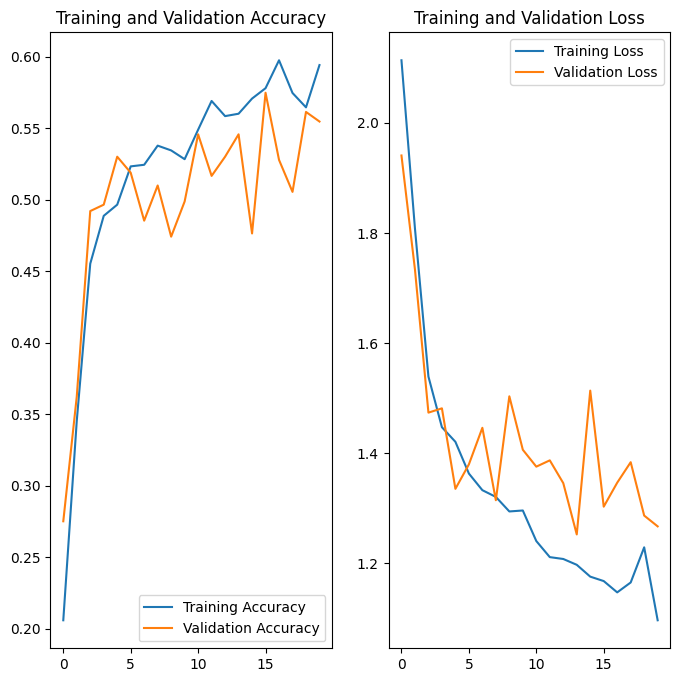

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


train_acc = history.history['accuracy'][-1] * 100
valid_acc = history.history['val_accuracy'][-1] * 100
train_loss = history.history['loss'][-1] * 100
valid_loss = history.history['val_loss'][-1] * 100

print(f"Training Accuracy: {train_acc:.2f}%")
print(f"Validation Accuracy: {valid_acc:.2f}%")
print(f"Training Loss: {train_loss:.2f}%")
print(f"Validation Loss: {valid_loss:.2f}%")

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

## **Findings from Second Model - Model using Augmentation Strategy**

 -  By leveraging augmentation strategy, overfitting has been effectively addressed.

 -  The training and validation accuracy of the aforementioned model fall within a similar range of 55% - 60%.

 -  Both the training and validation data are showing poor performance, indicating that the model is now exhibiting underfitting.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

## **Determining Class Imbalance**

In [ ]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    # Compute total images
    total_images = sum(count)

    # Compute percentage of images in each class
    percentage = [(c / total_images) * 100 for c in count]

    # Return dataframe with image count and percentage
    return pd.DataFrame(list(zip(sub_directory, count, percentage)),
                        columns=['Class', 'No. of Images', 'Percentage'])

df = class_distribution_count(data_dir_train)


# Print Class Distribution
print("Class Distribution:")
df

Class Distribution:


,Class,No. of Images,Percentage
0,vascular lesion,139,6.208129
1,nevus,357,15.944618
2,squamous cell carcinoma,181,8.083966
3,seborrheic keratosis,77,3.439035
4,melanoma,438,19.562305
5,pigmented benign keratosis,462,20.634212
6,actinic keratosis,114,5.091559
7,dermatofibroma,95,4.242966
8,basal cell carcinoma,376,16.793211


<ipython-input-29-dc17aab47f66>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Percentage", y="Class", data=df_sorted, palette="viridis")


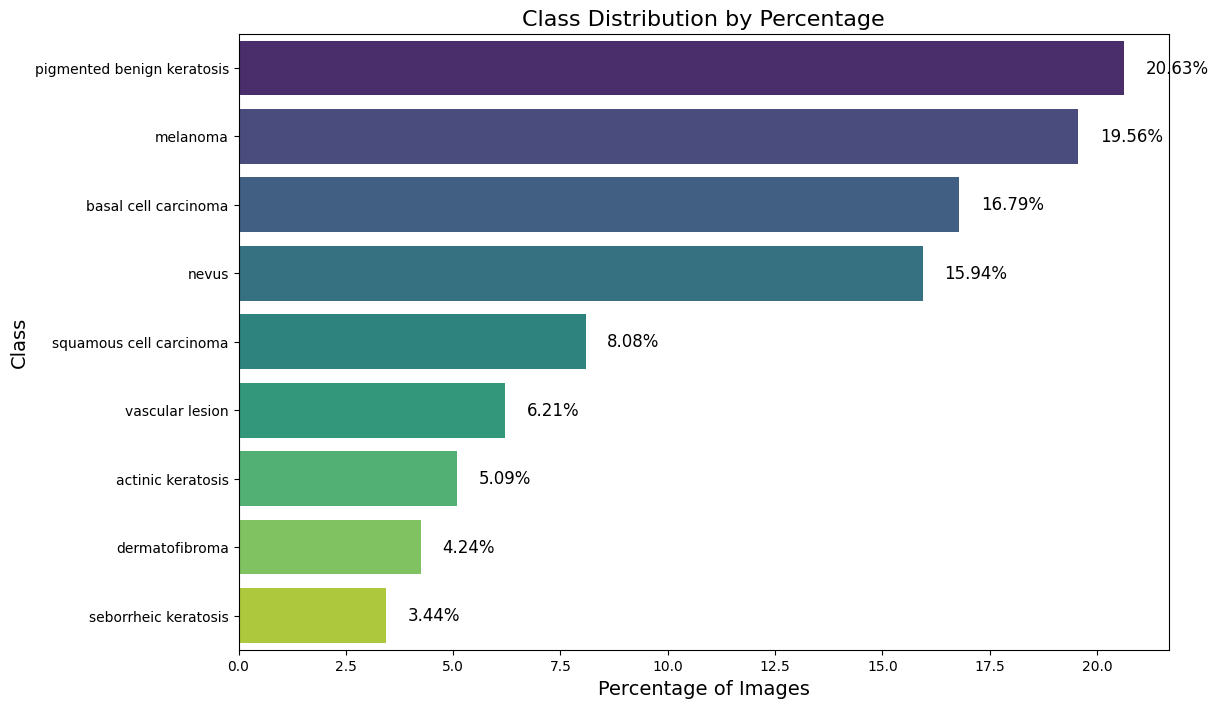

In [ ]:
#Visualize the Number of image in each class.

# Sort dataframe for better visualization
df_sorted = df.sort_values(by="Percentage", ascending=False)

# Plot bar chart
plt.figure(figsize=(12, 8))
sns.barplot(x="Percentage", y="Class", data=df_sorted, palette="viridis")

# Add labels and title
plt.xlabel("Percentage of Images", fontsize=14)
plt.ylabel("Class", fontsize=14)
plt.title("Class Distribution by Percentage", fontsize=16)

# Show values on bars
for index, value in enumerate(df_sorted["Percentage"]):
    plt.text(value + 0.5, index, f"{value:.2f}%", fontsize=12, va="center")

plt.show()

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?




## **Observations**

 -  A clear class imbalance is evident within the training data.
 -  squamous cell carcinoma has least number of samples, only 77.
 -  "Pigmented benign keratosis" and "melanoma" significantly outweigh other classes, representing approximately 20.63% and 19.56% of the data, respectively.

## **Handling Class Imbalances:** Rectify the class imbalances
#### **Context:** We can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
for i in class_names:

    # Delete old augmented images for the class
    output_path = str(data_dir_train / i / "output")
    shutil.rmtree(output_path, ignore_errors=True)  # Deletes 'output' folder if it exists

    p = Augmentor.Pipeline(str(data_dir_train / i))

    # Existing Rotation (to introduce variability)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)

    '''
    # Additional Recommended Augmentations
    p.flip_left_right(probability=0.5)  # Flip horizontally (if medically valid)
    p.flip_top_bottom(probability=0.5)  # Flip vertically (only if meaningful)
    p.zoom_random(probability=0.5, percentage_area=0.8)  # Random zoom
    p.random_contrast(probability=0.7, min_factor=0.7, max_factor=1.3)  # Contrast changes
    p.random_brightness(probability=0.7, min_factor=0.7, max_factor=1.3)  # Brightness variations
    p.random_distortion(probability=0.5, grid_width=4, grid_height=4, magnitude=8)  # Deformations
    p.skew(probability=0.5, magnitude=0.2)  # Slight geometric skew
    p.shear(probability=0.5, max_shear_left=10, max_shear_right=10)  # Shearing
    '''

    # Generate Augmented Samples
    p.sample(500)  # Adding 500 samples per class to balance dataset

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/coding/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78894C672090>: 100%|██████████| 500/500 [00:16<00:00, 29.80 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/coding/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78895ED0B910>: 100%|██████████| 500/500 [00:19<00:00, 25.68 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/coding/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78894C782C10>: 100%|██████████| 500/500 [00:18<00:00, 27.33 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/coding/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x78894C5108D0>: 100%|██████████| 500/500 [01:21<00:00,  6.11 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/coding/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x78894C64FB90>: 100%|██████████| 500/500 [01:15<00:00,  6.62 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/coding/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x78894C5C3E90>: 100%|██████████| 500/500 [00:18<00:00, 26.73 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/coding/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x78894C720390>: 100%|██████████| 500/500 [00:38<00:00, 12.95 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/coding/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x78894C5190D0>: 100%|██████████| 500/500 [00:16<00:00, 29.54 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/coding/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x78894C6DE710>: 100%|██████████| 500/500 [00:19<00:00, 25.47 Samples/s]


In [ ]:
# Define paths
output_base_dir = pathlib.Path(data_dir_train) / "output"

# Delete existing "output" directory if it exists
if output_base_dir.exists():
    shutil.rmtree(output_base_dir)  # Delete the folder and its contents

# Create a fresh "output" directory
output_base_dir.mkdir(exist_ok=True)

for class_name in class_names:
    class_dir = pathlib.Path(data_dir_train) / class_name  # Original class folder
    output_class_dir = output_base_dir / class_name  # Output class folder

    output_class_dir.mkdir(exist_ok=True)  # Create output class directory

    # Copy original images to the output directory
    for img_file in os.listdir(class_dir):
        img_path = class_dir / img_file
        if img_path.is_file():  # Ensure it's a file
            shutil.copy(img_path, output_class_dir / img_file)  # Copy original

    # Move augmented images from `output/` inside each class to final output folder
    augment_output_dir = class_dir / "output"
    if augment_output_dir.exists():
        for img_file in os.listdir(augment_output_dir):
            shutil.move(str(augment_output_dir / img_file), str(output_class_dir))

        os.rmdir(augment_output_dir)  # Remove empty folder

print("Original and Augmented images are now stored in:", output_base_dir)

Original and Augmented images are now stored in: /content/gdrive/My Drive/coding/Train/output


**Lets see the distribution of augmented data after adding new images to the original training data**

Class Distribution after augmentation:
                        Class  No. of Images  Percentage
0           actinic keratosis            614    9.111144
1        basal cell carcinoma            876   12.998961
2              dermatofibroma            595    8.829203
3                    melanoma            938   13.918979
4                       nevus            857   12.717020
5  pigmented benign keratosis            962   14.275115
6        seborrheic keratosis            577    8.562101
7     squamous cell carcinoma            681   10.105357
8             vascular lesion            639    9.482119


<ipython-input-32-b22d089acb53>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Percentage", y="Class", data=df2_sorted, palette="viridis")


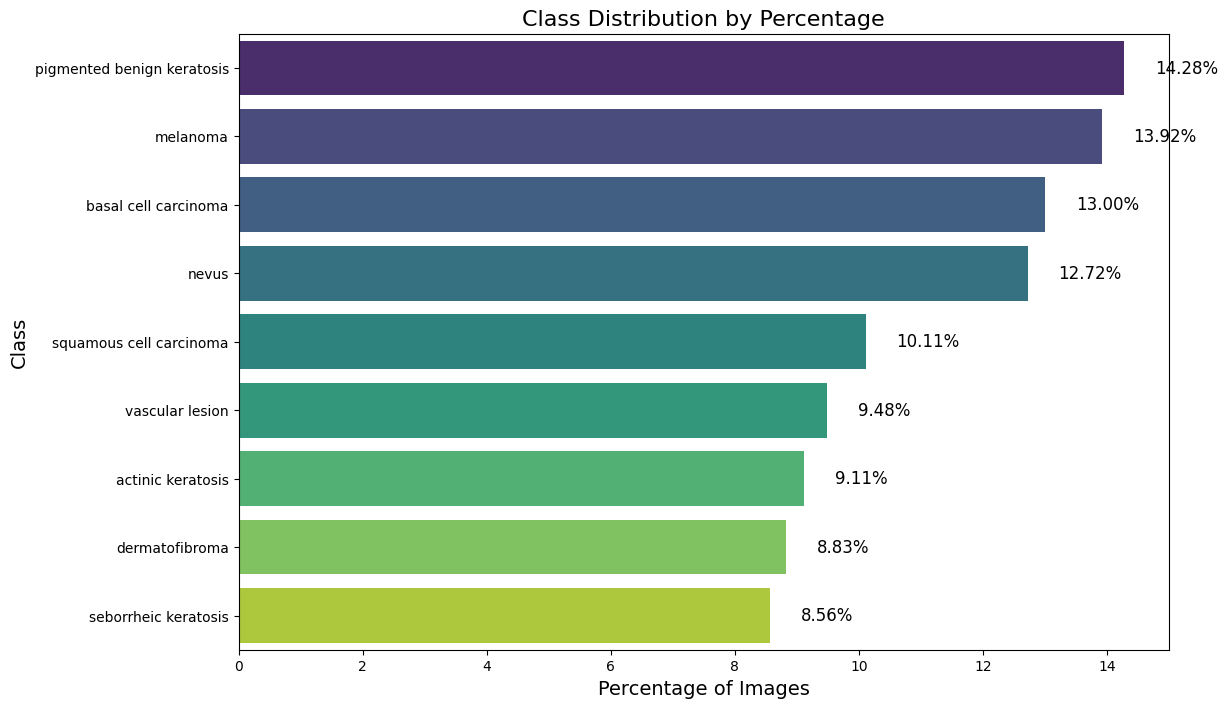

In [ ]:
df2 = class_distribution_count(output_base_dir)

# Print Class Distribution
print("Class Distribution after augmentation:")
print(df2)

#Visualize the Number of image in each class.

# Sort dataframe for better visualization
df2_sorted = df2.sort_values(by="Percentage", ascending=False)

# Plot bar chart
plt.figure(figsize=(12, 8))
sns.barplot(x="Percentage", y="Class", data=df2_sorted, palette="viridis")

# Add labels and title
plt.xlabel("Percentage of Images", fontsize=14)
plt.ylabel("Class", fontsize=14)
plt.title("Class Distribution by Percentage", fontsize=16)

# Show values on bars
for index, value in enumerate(df2_sorted["Percentage"]):
    plt.text(value + 0.5, index, f"{value:.2f}%", fontsize=12, va="center")

plt.show()

## **Create new Training and Validation dataset on Augmented data**

In [ ]:
train_ds2 = tf.keras.preprocessing.image_dataset_from_directory(
    output_base_dir,
    seed=123,
    validation_split=0.2,  # 20% of data will be used for validation
    subset="training",  # Correct value to select only the training data
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [ ]:
val_ds2 = tf.keras.preprocessing.image_dataset_from_directory(
    output_base_dir,
    seed=123,
    validation_split=0.2,  # 20% of data will be used for validation
    subset="validation",  # Correct value to select only validation data
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds2 = train_ds2.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds2 = val_ds2.cache().prefetch(buffer_size=AUTOTUNE)

## **Create the model on Augmented data**

In [ ]:
# Build the CNN model on augmented data
model = keras.Sequential([

    # Normalize pixel values (0-1)
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    # First Convolutional Block
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Second Convolutional Block
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Third Convolutional Block
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Flatten and Fully Connected Layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')  # Output layer
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## **Compile the model on Augmented data**
Choose an appropirate optimiser and loss function for model training

In [ ]:
### choose an appropirate optimiser and loss function
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Fixed learning rate
optimizer = tf.keras.optimizers.AdamW()
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       7,929,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,024,393 (30.61 MB)

 Trainable params: 8,024,393 (30.61 MB)

 Non-trainable params: 0 (0.00 B)

## **Train the model on Augmented data**

In [ ]:
epochs = 20
history = model.fit(
  train_ds2,
  validation_data=val_ds2,
  epochs=epochs
)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 56s 107ms/step - accuracy: 0.2182 - loss: 2.0637 - val_accuracy: 0.4625 - val_loss: 1.4415
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.4569 - loss: 1.4448 - val_accuracy: 0.5590 - val_loss: 1.2127
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.5595 - loss: 1.1937 - val_accuracy: 0.5657 - val_loss: 1.2000
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.6101 - loss: 1.0771 - val_accuracy: 0.5857 - val_loss: 1.0947
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.6636 - loss: 0.9308 - val_accuracy: 0.6763 - val_loss: 0.8711
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.7586 - loss: 0.6708 - val_accuracy: 0.6771 - val_loss: 0.9260
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.8048 - loss: 0.5753 - val_accuracy: 0.7179 - val_loss: 0.8328
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.8341 - loss: 0.4668 - val_a

## **Visualizing training results - Model on Augmented data**

Training Accuracy: 93.71%
Validation Accuracy: 79.73%
Training Loss: 15.73%
Validation Loss: 73.43%


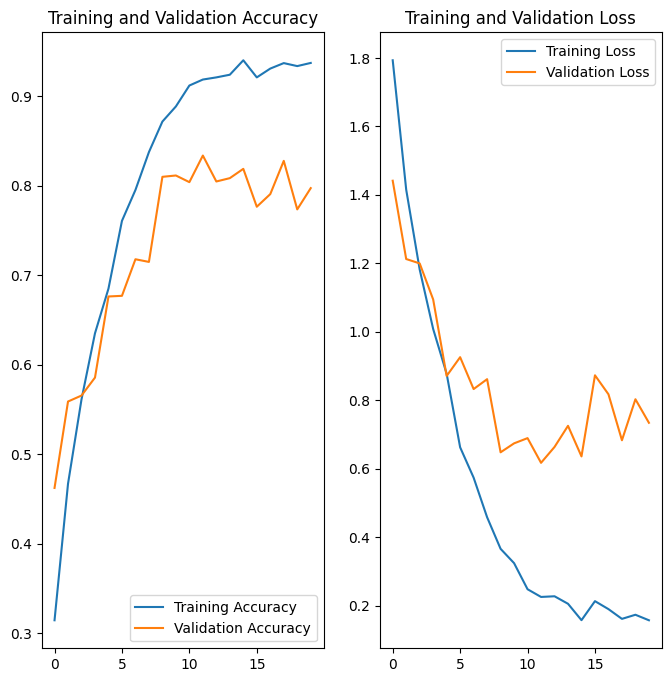

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


train_acc = history.history['accuracy'][-1] * 100
valid_acc = history.history['val_accuracy'][-1] * 100
train_loss = history.history['loss'][-1] * 100
valid_loss = history.history['val_loss'][-1] * 100

print(f"Training Accuracy: {train_acc:.2f}%")
print(f"Validation Accuracy: {valid_acc:.2f}%")
print(f"Training Loss: {train_loss:.2f}%")
print(f"Validation Loss: {valid_loss:.2f}%")

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## **Findings from Model on Augmented data**

 -  By handling class imbalances, both training and validation accuracy have been significantly improved - 94% and 80% respectively.
 -  The gap between training and validation accuracy indicates the lack of generalization in the model.

## **Scope of further improvements**

 -  We can further add complexity to model and increase epochs to increase the accuracy of the model.
 -  We can apply dropouts or batch normalization to improve generalization.

## **Fine-tune the model**
 - Increasing model complexity - introducing additional layers
 - Increasing number of epochs to improve accuracy
 - Dropouts
 - Batch Normalization

In [ ]:
# Adding layers, batch normalization and drop outs to prevent overfitting

#CNN Model Architecture

model = Sequential([
    # Normalize pixel values (0-1)
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    # First Convolutional Block
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),  # Prevent overfitting
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Second Convolutional Block
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),  # Prevent overfitting
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Third Convolutional Block
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),  # Prevent overfitting
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Flatten and Fully Connected Layers
    layers.Flatten(),
    layers.BatchNormalization(),
    layers.Dropout(0.5),  # Prevent overfitting
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),  # Prevent overfitting
    layers.Dense(len(class_names), activation='softmax')  # Output layer
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## **Compile the model**
Choose an appropirate optimiser and loss function for model training

In [ ]:
# choose an appropirate optimiser and loss function

optimizer = tf.keras.optimizers.AdamW(learning_rate=0.0001, weight_decay=0.01)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# ModelCheckpoint callback is employed alongside the model.fit() training process to periodically save the model and its weights (in a checkpoint file)
checkpoint = ModelCheckpoint("model.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)

# Early stop the training when a monitored metric ceases to show improvement
earlystop = EarlyStopping(monitor="val_accuracy", patience=5, mode="auto", verbose=1)

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 180, 180, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 90, 90, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 90, 90, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 45, 45, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 45, 45, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 61952)               │         247,808 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 8,467,369 (32.30 MB)

 Trainable params: 8,342,761 (31.83 MB)

 Non-trainable params: 124,608 (486.75 KB)

## **Train the model**

In [ ]:
epochs = 35
history = model.fit(
  train_ds2,
  validation_data=val_ds2,
  epochs=epochs,
  callbacks=[checkpoint, earlystop]
)

# Reload the best model (saved by ModelCheckpoint)
best_model = tf.keras.models.load_model("model.keras")

Epoch 1/35
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.3247 - loss: 2.1698
Epoch 1: val_accuracy improved from -inf to 0.08315, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 44s 185ms/step - accuracy: 0.3251 - loss: 2.1678 - val_accuracy: 0.0831 - val_loss: 3.2371
Epoch 2/35
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.5774 - loss: 1.2316
Epoch 2: val_accuracy improved from 0.08315 to 0.14922, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 57s 106ms/step - accuracy: 0.5775 - loss: 1.2313 - val_accuracy: 0.1492 - val_loss: 3.3429
Epoch 3/35
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.6868 - loss: 0.9148
Epoch 3: val_accuracy improved from 0.14922 to 0.24350, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 19s 112ms/step - accuracy: 0.6868 - loss: 0.9147 - val_accuracy: 0.2435 - val_loss: 2.9801
Epoch 4/35
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.7583 - loss: 0.6899
Epoch 4: val_accuracy improved from 0.2435

## **Visualizing training results**

Best Model Found at Epoch: 13
Best Training Accuracy: 95.85%
Best Validation Accuracy: 78.69%
Best Training Loss: 14.11%
Best Validation Loss: 68.76%


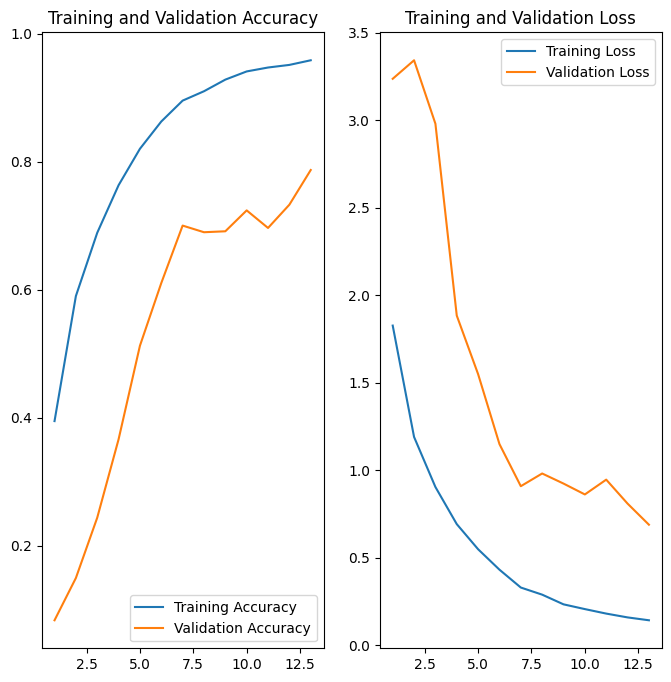

In [ ]:
# Reload the best model (saved by ModelCheckpoint)
best_model = tf.keras.models.load_model("model.keras")

# Find the best epoch (1-based index)
best_epoch = np.argmax(history.history['val_accuracy']) + 1  # Adding 1 because epochs start from 1

# Extract values only up to the best epoch
acc = history.history['accuracy'][:best_epoch]
val_acc = history.history['val_accuracy'][:best_epoch]
loss = history.history['loss'][:best_epoch]
val_loss = history.history['val_loss'][:best_epoch]

# Final metrics at the best epoch
best_train_acc = acc[-1] * 100
best_val_acc = val_acc[-1] * 100
best_train_loss = loss[-1] * 100
best_val_loss = val_loss[-1] * 100

# Print the best validation accuracy epoch & metrics
print(f"Best Model Found at Epoch: {best_epoch}")
print(f"Best Training Accuracy: {best_train_acc:.2f}%")
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"Best Training Loss: {best_train_loss:.2f}%")
print(f"Best Validation Loss: {best_val_loss:.2f}%")

# Plot only up to the best epoch
epochs_range = range(1, best_epoch + 1)  # Start from 1

plt.figure(figsize=(8, 8))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

## **Findings from Model with Dropout and Batch Normalization**

 -  Training accuracy has been increased to ~96%, due to increased layers in CNN architecture.
 -  The gap between training and validation accuracy has increased, indicating the drop in generalization in the model.
 -  We should try another model without Batch Normalization

## **Fine-tune the model - Without Batch Normalization**

In [ ]:
# CNN Model Architecture - without Batch Normalization

model = Sequential([
    # Normalize pixel values (0-1)
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    # First Convolutional Block
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.Dropout(0.2),  # Prevent overfitting
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Second Convolutional Block
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Dropout(0.2),  # Prevent overfitting
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Third Convolutional Block
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.Dropout(0.2),  # Prevent overfitting
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Flatten and Fully Connected Layers
    layers.Flatten(),
    layers.Dropout(0.5),  # Prevent overfitting
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.25),  # Prevent overfitting
    layers.Dense(len(class_names), activation='softmax')  # Output layer
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## **Compile the model - without Batch Normalization**
Choose an appropirate optimiser and loss function for model training

In [ ]:
# choose an appropirate optimiser and loss function

optimizer = tf.keras.optimizers.AdamW(learning_rate=0.0001, weight_decay=0.01)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# ModelCheckpoint callback is employed alongside the model.fit() training process to periodically save the model and its weights (in a checkpoint file)
checkpoint = ModelCheckpoint("model.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)

# Early stop the training when a monitored metric ceases to show improvement
earlystop = EarlyStopping(monitor="val_accuracy", patience=5, mode="auto", verbose=1)

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 180, 180, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 90, 90, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 45, 45, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │       7,929,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,218,153 (31.35 MB)

 Trainable params: 8,218,153 (31.35 MB)

 Non-trainable params: 0 (0.00 B)

## **Compile the model - without Batch Normalization**
Choose an appropirate optimiser and loss function for model training

In [ ]:
epochs = 50
history = model.fit(
  train_ds2,
  validation_data=val_ds2,
  epochs=epochs,
  callbacks=[checkpoint, earlystop]
)

# Reload the best model (saved by ModelCheckpoint)
best_model = tf.keras.models.load_model("model.keras")

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.1847 - loss: 2.0858
Epoch 1: val_accuracy improved from -inf to 0.41871, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 30s 136ms/step - accuracy: 0.1851 - loss: 2.0849 - val_accuracy: 0.4187 - val_loss: 1.7584
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.3964 - loss: 1.6088
Epoch 2: val_accuracy improved from 0.41871 to 0.50111, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 100ms/step - accuracy: 0.3965 - loss: 1.6085 - val_accuracy: 0.5011 - val_loss: 1.5318
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.4627 - loss: 1.4440
Epoch 3: val_accuracy improved from 0.50111 to 0.50334, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 20s 98ms/step - accuracy: 0.4628 - loss: 1.4438 - val_accuracy: 0.5033 - val_loss: 1.3983
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.4993 - loss: 1.3022
Epoch 4: val_accuracy improved from 0.50334

## **Visualizing training results - without Batch Normalization**

Best Model Found at Epoch: 27
Best Training Accuracy: 90.60%
Best Validation Accuracy: 84.86%
Best Training Loss: 23.83%
Best Validation Loss: 47.42%


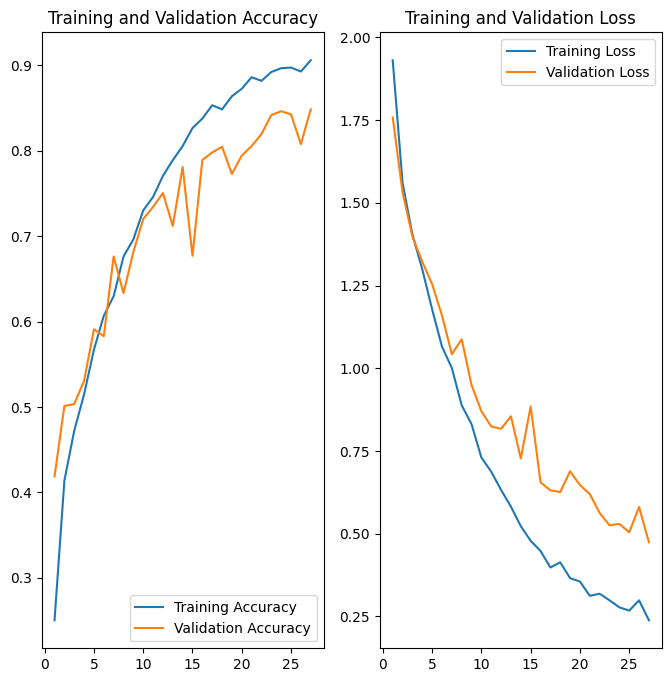

In [ ]:
# Reload the best model (saved by ModelCheckpoint)
best_model = tf.keras.models.load_model("model.keras")

# Find the best epoch (1-based index)
best_epoch = np.argmax(history.history['val_accuracy']) + 1  # Adding 1 because epochs start from 1

# Extract values only up to the best epoch
acc = history.history['accuracy'][:best_epoch]
val_acc = history.history['val_accuracy'][:best_epoch]
loss = history.history['loss'][:best_epoch]
val_loss = history.history['val_loss'][:best_epoch]

# Final metrics at the best epoch
best_train_acc = acc[-1] * 100
best_val_acc = val_acc[-1] * 100
best_train_loss = loss[-1] * 100
best_val_loss = val_loss[-1] * 100

# Print the best validation accuracy epoch & metrics
print(f"Best Model Found at Epoch: {best_epoch}")
print(f"Best Training Accuracy: {best_train_acc:.2f}%")
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"Best Training Loss: {best_train_loss:.2f}%")
print(f"Best Validation Loss: {best_val_loss:.2f}%")

# Plot only up to the best epoch
epochs_range = range(1, best_epoch + 1)  # Start from 1

plt.figure(figsize=(8, 8))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

## **Visualizing the Final Model Architecture**

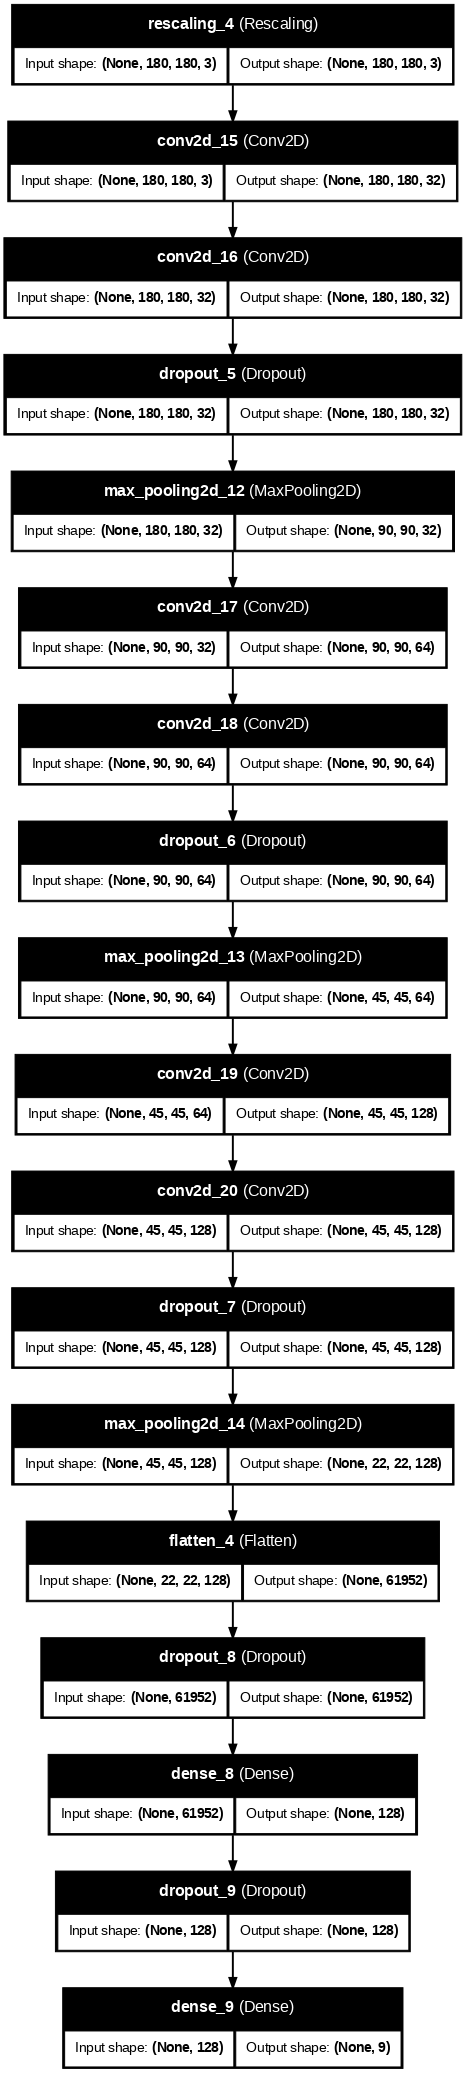

In [ ]:
# vizualizing the model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, dpi=70)

## **Model Evaluation on Test Data**

Testing our model on one of the instances in the test set - Although making predictions on Test Dataset is not part of the assignment (as listed in Evaluation Rubic)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Actual Class: basal cell carcinoma
Predicted Class: basal cell carcinoma


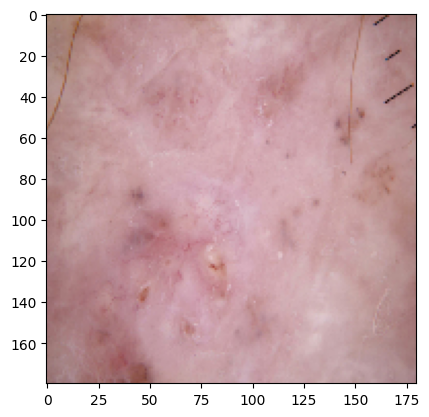

In [ ]:
# Evaluating our model on one of the instances in the test set

image_path_test = os.path.join(data_dir_test, class_names[1], '*')
test_image = glob(image_path_test)
test_image = load_img(test_image[-1], target_size=(180, 180, 3))
plt.imshow(test_image)
plt.grid(False)

img = np.expand_dims(test_image, axis=0)
predicted = best_model.predict(img)
predicted = np.argmax(predicted)
predicted_class = class_names[predicted]
print("Actual Class: " + class_names[1] +'\n'+ "Predicted Class: " + predicted_class)

## **Findings from the Final Model - without Batch Normalization**

 -  The final model attains an accuracy of **91% on the training** set and approximately **85% on the validation set**.

 -  The final model showcases **well-balanced performance**, displaying no signs of underfitting or overfitting.

 -  The implementation of class rebalancing has notably enhanced the model's performance across both training and validation datasets.

 -  The narrow divergence between training and validation accuracies underscores the robust generalization capability of the final CNN model.

 -  The addition of batch normalization failed to bring material enhancement in both training and validation accuracy.
  
 -  Increasing the layers in CNN architecture and increasing the number of epochs can futher improve model performace